## Prereqs
Run the reward predictor notebook if you haven't already done so to write the file `wrc.pkl`

In [7]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2


from joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
import tqdm
import opebet
import opebetrp
import pickle





In [8]:
with open('wrc.pkl','rb') as pkl:
    wrc=pickle.load(pkl)


def bet_gd(data, wmin, wmax, alpha):
    lb, ub = opebetrp.wealth_lb_gd(data, wmin, wmax, alpha)
    return np.array(lb), np.array(ub)

In [10]:
wrgd = np.copy(wrc[:,0:2])

N = 5

flb = 0
fub = 0
for i in range(N):
    lbgd, ubgd = bet_gd(wrgd[10000*i:10000*(i+1)], 0, 100, 0.01)
    flb = flb + lbgd
    fub = fub + ubgd
lbgd = flb/N
ubgd = fub/N

100%|█████████████████████████████████████| 10000/10000 [03:45<00:00, 44.37it/s]


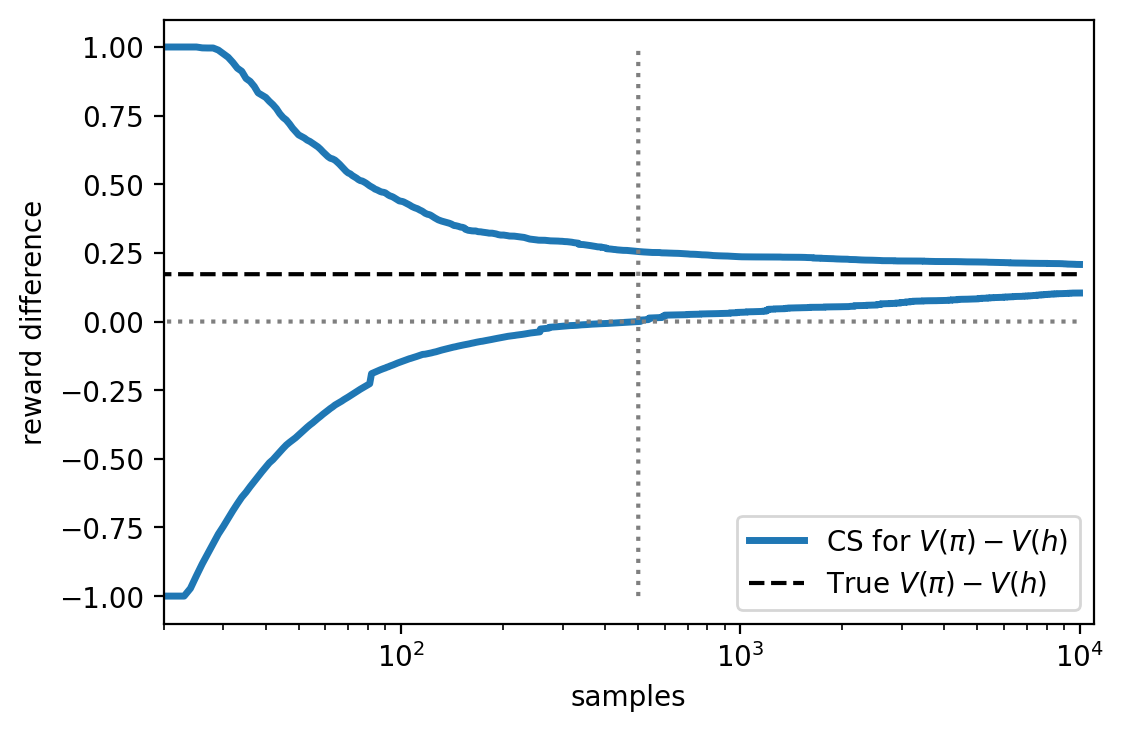

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
j=7
t = 1+np.arange(len(lbgd))
ax.plot(t,lbgd,'-',color=colors[0],linewidth=2.5, label='CS for $V(\pi)-V(h)$')
ax.plot(t,ubgd,'-',color=colors[0],linewidth=2.5)
ax.plot(t,0.1724665914082657*np.ones_like(t),'k--', label='True $V(\pi)-V(h)$')
ax.plot(t,np.zeros_like(t),':',color=colors[j])
ax.plot(np.argmax(lbgd>0)*np.ones_like(t),np.linspace(-1,1,len(t)),':',color=colors[j])
ax.set(xscale='log',xlim=[20,11000], xlabel='samples', ylabel='reward difference')
ax.legend(loc='lower right')
fig.savefig('gd.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
mem = Memory("./mycache")

@mem.cache
def get_more_data():
    data = load_svmlight_file("xab")
    return data[0], data[1]

X, y = get_more_data()

In [15]:
from scipy.special import softmax, expit

class behavior_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.w = npz['wlin']
        k = self.w.shape[1]
        self.u = np.ones(k)/k
        self.m = 0.9
        
    def __call__(self, x):
        t = self.m*softmax((x @ self.v) @ self.w, axis=-1)+(1-self.m)*self.u
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class eval_policy(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.w = npz['w']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = softmax(rff @ self.w, axis=-1)
        t /= t.sum(axis=-1, keepdims=1)
        return np.squeeze(t)
    
class reward_predictor(object):
    def __init__(self, name):
        with np.load(name) as npz:
            self.v = npz['v']
            self.f = npz['omega']
            self.b = npz['b']
            self.z = npz['z']
            self.q = npz['q']
        
    def __call__(self, x):
        rff = ((x/255.) @ self.v) @ self.f + self.b
        np.cos(rff, out=rff)
        rff *= self.z
        t = expit(rff @ self.q)
        return np.squeeze(t)

h = behavior_policy('mnist_models.npz')
pi = eval_policy('mnist_models.npz')
q = reward_predictor('mnist_models.npz')

In [16]:
chunk = 1000
reward_pi = 0
reward_h = 0
iy = y.astype(np.int32)

for i in tqdm.trange(0,1000000,chunk):
    probs = pi(X[i:i+chunk])
    reward_pi += np.sum(probs[range(chunk),iy[i:i+chunk]])
    probs = h(X[i:i+chunk])
    reward_h += np.sum(probs[range(chunk),iy[i:i+chunk]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.86it/s]


In [17]:
np.argmax(lbgd>0)

501

In [25]:
true_diff = reward_pi/y.size-reward_h/y.size
print('reward diff:',true_diff)

reward diff: 0.17246661215439596


In [26]:
chunk = 1000
r_pi = []
r_h = []
iy = y.astype(np.int32)

for i in tqdm.trange(0,50000,chunk):
    probs = pi(X[i:i+chunk])
    r_pi.extend(probs[range(chunk),iy[i:i+chunk]])
    probs = h(X[i:i+chunk])
    r_h.extend(probs[range(chunk),iy[i:i+chunk]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.23it/s]


In [27]:
def bet_1d(data_pi, data_h, wmin, wmax, alpha):
    half_pi = data_pi[:len(data_pi)//2]
    w = np.ones_like(half_pi)
    half_h = data_h[len(data_pi)//2:2*(len(data_pi)//2)]
    lb_pi, ub_pi = opebet.wealth_lb_1d(np.stack((w,half_pi), axis=-1), wmin, wmax, 0.5*alpha)
    lb_h, ub_h = opebet.wealth_lb_1d(np.stack((w,half_h), axis=-1), wmin, wmax, 0.5*alpha)
    return np.array(lb_pi)-np.array(ub_h), np.array(ub_pi)-np.array(lb_h)

def upsample(x):
    c = np.empty((2 * x.size - 1,), dtype=x.dtype)
    c[0::2] = x
    c[1:-1:2] = 0.5*(x[:-1]+x[1:])
    return c

In [28]:
flb = 0
fub = 0
N = 5
for i in range(N):
    lbab, ubab = bet_1d(r_pi[10000*i:10000*(i+1)], r_h[10000*i:10000*(i+1)], 0, 2, 0.01)
    lbab = upsample(lbab)
    ubab = upsample(ubab)
    flb = flb + lbab
    fub = fub + ubab
lbab = flb/N
ubab = fub/N

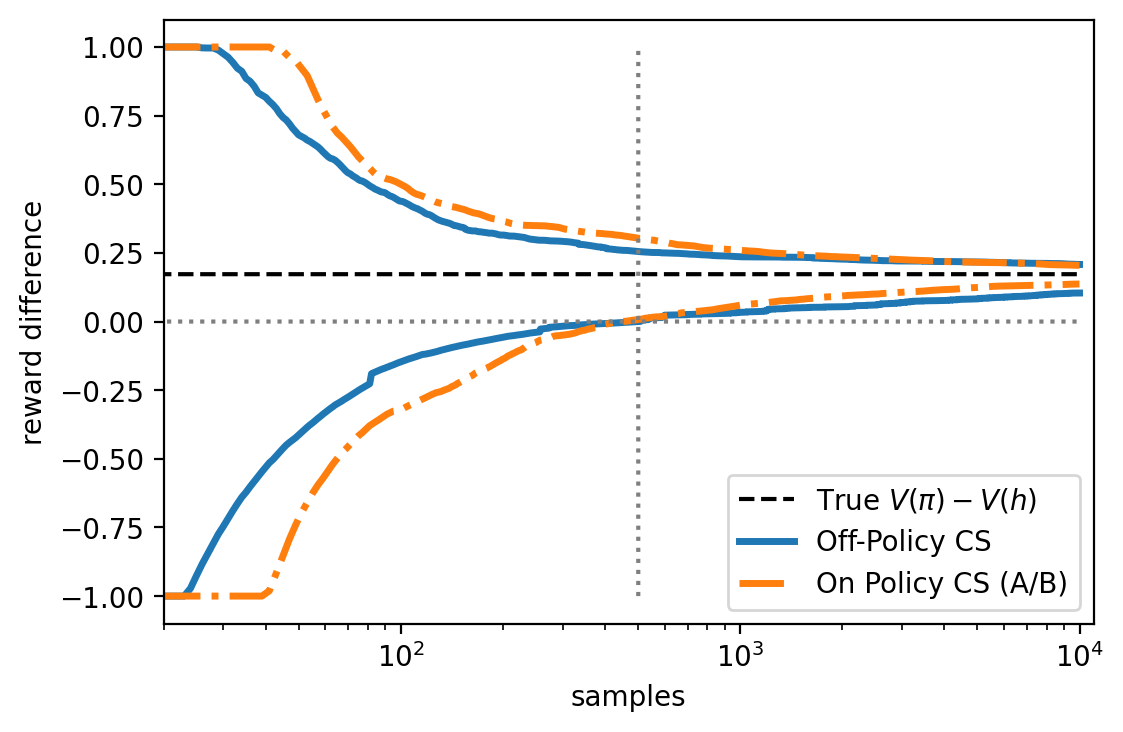

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap    
fig, ax = plt.subplots(dpi=200)
colors = get_cmap("tab10").colors 
j=7
t = 1+np.arange(len(lbgd))
ta = 1+np.arange(len(lbab))
ax.plot(t,true_diff*np.ones_like(t),'k--', label='True $V(\pi)-V(h)$')
ax.plot(t,lbgd,'-',color=colors[0],linewidth=2.5, label='Off-Policy CS')
ax.plot(t,ubgd,'-',color=colors[0],linewidth=2.5)
ax.plot(ta,lbab,'-.',color=colors[1],linewidth=2.5, label='On Policy CS (A/B)')
ax.plot(ta,ubab,'-.',color=colors[1],linewidth=2.5)

ax.plot(t,np.zeros_like(t),':',color=colors[j])
ax.plot(np.argmax(lbgd>0)*np.ones_like(t),np.linspace(-1,1,len(t)),':',color=colors[j])
ax.set(xscale='log',xlim=[20,11000], xlabel='samples', ylabel='reward difference')
ax.legend(loc='lower right')
fig.savefig('gd2.pdf', bbox_inches='tight', pad_inches=0)